In [1]:
import time
import os
import datetime
import random
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
# import haversine as hs
from matplotlib.patches import Patch
# from haversine import Unit
from shapely.geometry import Point, Polygon, LineString
# from math import radians, cos, sin, asin, sqrt
# from collections import defaultdict

NOT_AVAILABLE_MSG = "No Available Trip in The Given Service Day"



In [2]:
trips_df = pd.read_csv("../../../data/mmt_gtfs/trips.csv")
routes_df = pd.read_csv("../../../data/mmt_gtfs/routes.csv")
stops_df = pd.read_csv("../../../data/bus_route_stop_info/stops.csv")
stops_df = stops_df[stops_df["Route"] != "None"]  # filter stops that are not currently in service
stop_times_df = pd.read_csv("../../../data/mmt_gtfs/stop_times.csv")
city = gpd.read_file("../../../data/plot/background/madison-shp")
water = gpd.read_file("../../../data/plot/background/water-shp")
street = gpd.read_file("../../../data/plot/background/streets-shp")
zones = gpd.read_file("../../../data/plot/background/zoning_districts-shp")
zones = zones.dropna(subset=["ZONING_COD"])  # filter districts without ZONING_COD data

In [3]:
# t0 = datetime.timedelta(hours=5, minutes=32, seconds=0)
# t1 = datetime.timedelta(hours=6, minutes=32, seconds=0)
# t2 = datetime.timedelta(hours=7, minutes=32, seconds=0)
# t3 = datetime.timedelta(hours=7, minutes=40, seconds=0)
# t4 = datetime.timedelta(hours=8, minutes=32, seconds=0)
# t5 = datetime.timedelta(hours=9, minutes=32, seconds=0)
#
# tt0 = datetime.timedelta(hours=5, minutes=39, seconds=0)
# tt1 = datetime.timedelta(hours=6, minutes=38, seconds=0)
# tt2 = datetime.timedelta(hours=7, minutes=37, seconds=0)
# tt3 = datetime.timedelta(hours=7, minutes=36, seconds=0)
# tt4 = datetime.timedelta(hours=8, minutes=35, seconds=0)
# tt5 = datetime.timedelta(hours=9, minutes=34, seconds=0)
#
# st1 = pd.Series([t0, t1, t2, t3, t4, t5])
# st2 = pd.Series([tt0, tt1, tt2, tt3, tt4, tt5])
#
# diff = st2 - st1
# diff.sort_values().dt.total_seconds()


# trips_by_serv = trips_df[trips_df["service_id"].isin(serv_types["wkd"])]
# matched_stops = stop_times_df[stop_times_df["stop_id"].isin([7605])]
# filtered_trips = trips_by_serv[trips_by_serv["trip_id"].isin(matched_stops["trip_id"])]
# matched = matched_stops[matched_stops["trip_id"].isin(filtered_trips["trip_id"])]
# schedules = pd.to_timedelta(matched["arrival_time"])
# times = pd.Series([datetime.timedelta(hours=7, minutes=30, seconds=0)] * len(schedules), index=schedules.index)
# diff = schedules - times
# sorted_diff_sec = diff.sort_values().dt.total_seconds()
# sorted_diff_sec
# diff_sec = sorted_diff_sec[sorted_diff_sec > 0]
# chosen_trip = diff_sec.index[0]
#
# # matched[matched["trip_id"] == chosen_trip]
# diff_sec
# matched.loc[chosen_trip]["stop_id"]
# stops_df["Route"]

a = [1, 2, 5, 4]
list(map(str, sorted(a)))

['1', '2', '4', '5']

In [86]:
# service type
serv_types = {
    "wkd": ["93_WKD", "93_WKD:L#6", "93_WKD:L=6", "93_WKD:R",
            "93_WKD:S", "93_WKD:S#6", "93_WKD:S=6"],
    "sat": ["93_SAT", "93_SAT:L", "93_SAT:R", "93_SAT:S"],
    "sun": ["93_SUN", "93_SUN:L", "93_SUN:R", "93_SUN:S"],
    "hol": ["93_D24", "93_D31", "93_HOL", "93_HOL:R"],
    "mwk": ["93_MWK", "93_MWK:R"]}

zone_category = {
    "Residential Districts": [
        "SR-C1", "SR-C2", "SR-C3",
        "SR-V1", "SR-V2", "TR-C1",
        "TR-C2", "TR-C3", "TR-C4",
        "TR-V1", "TR-V2", "TR-U1",
        "TR-U2", "TR-R",  "TR-P"
    ],
    "Commercial and Mixed-Use Districts": [
        "LMX", "NMX", "TSS", "MXC", "CC-T", "CC"
    ],
    "Employment Districts": [
        "TE", "SE", "SEC", "EC", "IL", "IG"
    ],
    "Downtown and Urban Districts": [
        "DC", "UOR", "UMX", "DR1", "DR2"
    ],
    "Special Districts": [
        "A", "UA", "CN", "PR", "AP", "CI", "PD", "PMHP"
    ],
    "Overlay Districts": [
        "WP", "W", "TOD", "NC", "F1", "F2", "F3", "F4"
    ],
    "Historic Districts": [
        "HIST-L", "HIST-MH", "HIST-TL", "HIST-UH", "HIST-MB", "HIST-FS"
    ]
}

def generate_random(num_points, zones):
    """
    Take as input a numpoints and a list of polygons,
    output a list of points within the given polygons

    Args:
        num_points: number of points generated
        zones:      zones shp file
    Returns:
         A dictionary of points (vals) categorized into 5 zoning districts (keys).
    """
    points_by_zone = {}

    for key, val in zone_category.items():

        # TODO: re-estimate the points generating algorithm for more uniformly distributed
        z = zones[zones["ZONING_COD"].isin(val)]
        if len(z) == 0:
            continue
        else:
            points_by_zone[key] = []
            while len(points_by_zone[key]) < num_points:
                choice_idx = random.choice(range(len(z)))
                polygon = z.iloc[choice_idx, -1]
                minx, miny, maxx, maxy = polygon.bounds
                pnt = Point(random.uniform(minx, maxx),
                            random.uniform(miny, maxy))
                if polygon.contains(pnt):
                    points_by_zone[key].append(pnt)
    return points_by_zone

def plot_random(random_points, ax, **kwargs):
    """
    Generate a geo-plot using points generated by the generate_random() method.

    Args:
         random_points: points returned by generate_random() method
         ax:            ax to plot the geo map
         **kwargs:      setting of the geo map
    Returns:
        A dictionary of points (vals) categorized into 5 zoning districts (keys).
    """

    # -----------------------------------------------------------------------
    # --- hard coded colors indicating different districts ------------------
    # --- may need to add more colors when more categories are added --------
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:olive"]
    # -----------------------------------------------------------------------

    handles = []
    points = random_points  # points_by_zone
    c_pick = 0
    for key, pts in points.items():
        c = colors[c_pick]
        c_pick += 1
        x = []
        y = []
        for pt in pts:
            x.append(float(pt.x))
            y.append(float(pt.y))
        handle = plt.scatter(x, y, c=c, **kwargs)
        handles.append(handle)
    plt.legend(handles=handles, labels=points.keys(), frameon=False, loc="upper left", fontsize=15)

    return points

# source: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def find_near_stops(points, stops_df, threshold=400):
    """
    Find the nearest bus stops for each point in the points parameter.

    Args:
        points:    a list of shapely Point objects
        stops_df:
        threshold: find number of bus stops within the distance threshold (in meters)
                   by default is 400 meters (or 1/4 miles). e.g. number of bus stops
                   within 400 meters from one generated point.
    Returns:
        a DataFrame of columns: districts, stop_id, stop_lat, stop_lon,
                                pt_lon, pt_lat, distance (in meters),
                                num_available_stops, num_available_routes, ids_dist
    """
    ids =        []  # store the stop id of the nearest bus stop
    dists =      []  # store the shortest distance to the nearest bus stop
    stop_lons =  []  # longitude of the stop id
    stop_lats =  []  # latitude of the stop id
    pt_lons =    []  # longitude of the generated pt
    pt_lats =    []  # latitude of the generated pt
    districts =  []  # district name where the pt is generated
    num_stops =  []  # number of available bus stops within the distance threshold (None if the nearest one > threshold)
    routes =     []  # available routes within the distance threshold (None if the nearest one > threshold)
    num_routes = []  # number of avaialable routes within the distance threshold (None if the nearest one > threshold)
    ids_dist =   []  # list of tuples of (stop_ids, distances) to the bus stop (None if the nearest one > threshold)

    for key, pts in points.items():
        for pt in pts:
            xs = [pt.x] * len(stops_df)
            ys = [pt.y] * len(stops_df)

             # element wise operation to calculate distances
            kms = haversine_np(xs, ys, stops_df["stop_lon"], stops_df["stop_lat"])

            idx = kms.idxmin()  # index of the smallest value
            stop_id = stops_df.loc[idx, "stop_id"]
            lon = stops_df.loc[idx, "stop_lon"]
            lat = stops_df.loc[idx, "stop_lat"]
            dist = round(kms.loc[idx] * 1000, 2)  # convert km to meters

            ids.append(stop_id)
            stop_lons.append(lon)
            stop_lats.append(lat)
            pt_lons.append(pt.x)
            pt_lats.append(pt.y)
            dists.append(dist)
            districts.append(key)

            # calculate number of available bus stops and routes
            # within the threshold distance

            ####################################################################
            ##################    Optimization approach    #####################
            ####################################################################
            #
            # ms = kms * 1000
            # fitered_ms = ms[ms <= threshold]
            # sorted_filtered_ms = fitered_ms.sort_values(ascending=True)
            # num_stops_cnt = len(sorted_filtered_ms)
            # num_routes_cnt = stops_df[stops_df.index.isin([sorted_filtered_ms.index])]["Route"].str.split(",")
            # ids_dist_tuple = list(pd.DataFrame(
            #                             {
            #                                 'stop_id': stops_df[stops_df["stop_id"].isin([sorted_filtered_ms.index])]["stop_id"],
            #                                 'dist': np.round(sorted_filtered_ms.values, 2)
            #                             }).to_records(index=False))
            ####################################################################
            ####################################################################
            ####################################################################

            sorted_km = kms.sort_values(ascending=True)
            num_stops_cnt  = 0
            num_routes_cnt = []
            ids_dist_tuple = []
            for idx, val in sorted_km.items():
                dist = round(val * 1000, 2)
                if dist <= threshold:
                    num_stops_cnt += 1
                    ids_dist_tuple.append((stops_df.loc[idx, "stop_id"], dist))
                    num_routes_cnt.extend(stops_df.loc[idx, "Route"].split(", "))
                else:
                    break

            num_stops.append(num_stops_cnt)
            routes.append(sorted(map(int, list(set(num_routes_cnt)))))
            num_routes.append(len(list(set(num_routes_cnt))))
            ids_dist.append(ids_dist_tuple)

    stops = pd.DataFrame({
        "districts": districts,
        "pt_lon": pt_lons,
        "pt_lat": pt_lats,
        "stop_id (nearest)": ids,
        "stop_lon (nearest)": stop_lons,
        "stop_lat (nearest)": stop_lats,
        "distance (nearest, in meters)": dists,
        "num_available_stops (within {}m)".format(threshold): num_stops,
        "num_available_routes (within {}m)".format(threshold): num_routes,
        "available_routes (within {}m)".format(threshold): routes,
        "ids_dist": ids_dist
    })
    return stops

def connect_to_stops(ax, stops):
    """
    Draw a line from randomly generated points to nearest bus stops that are in service.

    Args:
        ax: ax to draw lines
        stops: stops dataframe returned by find_near_stop() method
    Returns:
        None
    """
    linestrings = []
    for idx, row in stops.iterrows():
        ls = LineString([(row["pt_lon"], row["pt_lat"]),
                         (row["stop_lon (nearest)"], row["stop_lat (nearest)"])])
        linestrings.append(ls)

    df = pd.DataFrame({"geometry":linestrings})
    df.set_geometry("geometry").plot(ax=ax, color="k", linestyle="--", alpha=0.5)


def minute_wait(stops, t, serv, trips_df, stop_times_df):
    """
    Find the soonest coming bus and calculate the expected waiting times,
    given the time and service type

    Args:
        stops: stops dataframe returned by the find_near_stops columns
        t:     time, datatime object
        serv:  service type (wkd, sat, sun, hol, mwk)
    Returns:

    """

    # filtered trips by service type
    trips_by_serv = trips_df[trips_df["service_id"].isin(serv_types[serv])]

    min_waits = []     # list of minimum waiting time
    chosen_trip_ids = []  # list of minimum waiting time trip_id
    chosen_stop_ids = []  # list of chosen stop_id


    for idx, row in stops.iterrows():

        # if there are many bus stops within the threshold distance,
        # we want to find the soonest coming bus from all near bus stops
        # else use the nearest if no bus stops nearby
        stop_ids = []
        if len(row["ids_dist"]) == 0:
            stop_ids = [row["stop_id (nearest)"]]
        else:
            stop_ids = [tup[0] for tup in row["ids_dist"]]


        # filter stop_id by service type
        matched_stops = stop_times_df[stop_times_df["stop_id"].isin(stop_ids)]
        filtered_trips = trips_by_serv[trips_by_serv["trip_id"].isin(matched_stops["trip_id"])]
        matched = matched_stops[matched_stops["trip_id"].isin(filtered_trips["trip_id"])]

        # find waiting time for the soonest coming route and trip_id of that route
        schedules = pd.to_timedelta(matched["arrival_time"])

        if len(schedules) != 0:
            times = pd.Series([datetime.timedelta(hours=t.hour,
                                                  minutes=t.minute,
                                                  seconds=t.second)] * len(schedules), index=schedules.index)
            diff = schedules - times
            sorted_diff_sec = diff.sort_values().dt.total_seconds()
            diff_sec = sorted_diff_sec[sorted_diff_sec > 0]
            if len(diff_sec) == 0:
                #############################################################################
                ##########   there're routes that only run at a certain time   ##############
                ##########   e.g. in the morning                               ##############
                #############################################################################
                min_waits.append(None)
                chosen_trip_ids.append(None)
                chosen_stop_ids.append(None)
            else:
                min_waits.append(diff_sec.iloc[0] / 60)
                chosen_trip_ids.append(matched.loc[diff_sec.index[0]]["trip_id"])
                chosen_stop_ids.append(matched.loc[diff_sec.index[0]]["stop_id"])
        else:
            min_waits.append(None)
            chosen_trip_ids.append(None)
            chosen_stop_ids.append(None)

    stops["minutes_wait"] = min_waits
    stops["trip_id (chosen)"] = chosen_trip_ids
    stops["stop_id (chosen)"] = chosen_stop_ids

    # find the route that's coming by trip_id
    route_coming = []
    for idx, row in stops.iterrows():
        trip_id = row["trip_id (chosen)"]
        try:
            if np.isnan(trip_id):
                route_coming.append(NOT_AVAILABLE_MSG)
            else:
                route_coming.append(trips_df[trips_df["trip_id"].isin([trip_id])]["route_short_name"].iloc[0])
        except TypeError:
                route_coming.append(NOT_AVAILABLE_MSG)
    stops["coming_route"] = route_coming

    return stops


def get_service_type(serv):
    """convert service_type for the use of plot title"""
    if serv == "wkd":
        return " on Weekday"
    if serv == "sat" or serv == "sun":
        return " on Weekend"
    if serv == "hol":
        return " on Holiday"
    else:
        return " on Modified Week"

def get_full_time(t):
    """convert time object for the use of plot title"""
    return " at " + str(t.hour) + ":" + str(t.minute) + ":" + str(t.second)

def generate_sim(num_points, t, serv,
                 stops_df, stop_times_df, trips_df,
                 coords=None, threshold=400, geo_plot=False):
    """
    Randomly generates points in Madison and calculates nearest stop_id, lon/lat, distance
    from each point, and calculates the number of available stops/routes within the given
    threshold distance, and estimates the minimum waiting time from all avaialable stops within the
    given threshold distance.

    Args:
        num_points:
        t:
        serv:
        coords: if not given, randomly generate points using generate_random() method
        threshold:
        bar_plot:
        geo_plot:
    Return:
        A dataframe of simulated data and a randomly generated points for the use of
        generating a set of simulations of different times and service types.
    """
    pts = 0
    if coords == None:
        start = time.time()
        pts = generate_random(num_points, zones)
        end = time.time()
        # print("generate random points " + str(round((end - start) * 1000, 2)) + "ms")
    else:
        pts = coords

    start = time.time()
    stops = find_near_stops(pts, stops_df, threshold)
    end = time.time()
    # print("find near stops " + str(round((end - start) * 1000, 2)) + "ms")

    start = time.time()
    stops = minute_wait(stops, t, serv, trips_df, stop_times_df)
    end = time.time()
    # print("find waiting time " + str(round((end - start) * 1000, 2)) + "ms")

    # --------- plot background ---------
    if geo_plot:
        fig, ax = plt.subplots(figsize=(12, 10))
        city.plot(ax=ax, color="0.9")
        water.plot(ax=ax, color="0.7")
        street.plot(ax=ax, color="0.8")

        dot_size = 20
        # --------- plot random points ---------
        start = time.time()
        points = plot_random(pts, ax=ax, s=dot_size, zorder=5, alpha=0.4)
        end = time.time()
        print("plot random points " + str(round((end - start) * 1000, 2)) + "ms")

        # --------- plot bus stops ---------
        start = time.time()
        # stops.plot.scatter("lon", "lat", ax=ax, c=colors, s=35, zorder=5, alpha=0.4, marker='o', facecolor="None")
        plt.plot(stops["stop_lon (nearest)"], stops["stop_lat (nearest)"], 'x',
                 markersize=dot_size*0.3, markerfacecolor="None",
                 markeredgecolor="red", markeredgewidth=0.5,
                 alpha=0.3, zorder=5, label="Bus Stop")
        end = time.time()
        print("plot bus stops " + str(round((end - start) * 1000, 2)) + "ms")

        # --------- draw lines between pts and stops ---------
        start = time.time()
        connect_to_stops(ax, stops)

        end = time.time()
        print("draw lines between pts and stops " + str(round((end - start) * 1000, 2)) + "ms")

        # --------- save figure to file ---------
        # TODO: when save, uncomment this
        start = time.time()
        ax.set_axis_off()
        ax.set_title(str(num_points) + " Random Samples Per Zone, " + str(num_points * 5) +
                     " in Total," + get_full_time(t) + get_service_type(serv), size=19)

        if not os.path.exists("sim_sample"):
            os.mkdir("sim_sample")

        current_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H-%M-%S')
        dirname = current_time[:current_time.index("_")]

        if not os.path.exists(os.path.join("sim_sample", dirname)):
            os.mkdir(os.path.join("sim_sample", dirname))

        plt.savefig(os.path.join("sim_sample",
                                 dirname,
                                (current_time[current_time.index("_"):] + ".png")),
                    dpi=300, bbox_inches="tight")
        end = time.time()
        print("saving figure " + str(round((end - start) * 1000, 2)) + "ms")

    return pts, stops

# t = datetime.time(7, 30, 00)
# serv = "wkd"
# start = time.time()
# points, wkd = generate_sim(10, t, serv, stops_df, stop_times_df, trips_df)
# end = time.time()
# print("total execution time " + str(round((end - start) * 1000, 2)) + "ms")

In [79]:
wkd.head(3)

,districts,pt_lon,pt_lat,stop_id (nearest),stop_lon (nearest),stop_lat (nearest),"distance (nearest, in meters)",num_available_stops (within 400m),num_available_routes (within 400m),available_routes (within 400m),ids_dist,minutes_wait,trip_id (chosen),stop_id (chosen),coming_route
0,Residential Districts,-89.397431,43.053541,362,-89.396558,43.053756,74.82,12,5,"[4, 5, 13, 44, 48]","[(362, 74.82), (107, 118.61), (146, 150.62), (...",4.400000,1019841,181,5
1,Residential Districts,-89.521650,43.018055,8351,-89.505909,43.019410,1287.72,0,0,[],[],12.250000,1023689,8351,51
2,Residential Districts,-89.496423,43.018208,8739,-89.502974,43.020011,568.73,0,0,[],[],12.733333,1023689,8739,51


In [80]:
dts = []
for hr in range(24):
    if hr > 4:
        dts.append("{}:00:00".format(hr))
        if hr == 23:
            break
        dts.append("{}:30:00".format(hr))

ds  = list(zone_category.keys())[:5]

pts = None
dfs = []
time_df = pd.DataFrame(index=dts, columns=ds)
servs = ["wkd", "sat", "hol"]
for serv in servs:
    print(serv)
    time_df = pd.DataFrame(index=dts, columns=ds)
    for dt in dts:
        t = dt.split(":")

        if pts == None:
            pts, df = generate_sim(600, datetime.time(int(t[0]), int(t[1]), int(t[2])),
                                   serv, stops_df, stop_times_df, trips_df)
        else:
            _, df = generate_sim(600, datetime.time(int(t[0]), int(t[1]), int(t[2])),
                                   serv, stops_df, stop_times_df, trips_df, coords=pts)

        for dist in ds:
            time_df.loc[dt, dist] = df[df["districts"] == dist]["minutes_wait"].dropna().mean()

    dfs.append(time_df)

wkd
sat
hol


In [81]:
len(dfs)

3

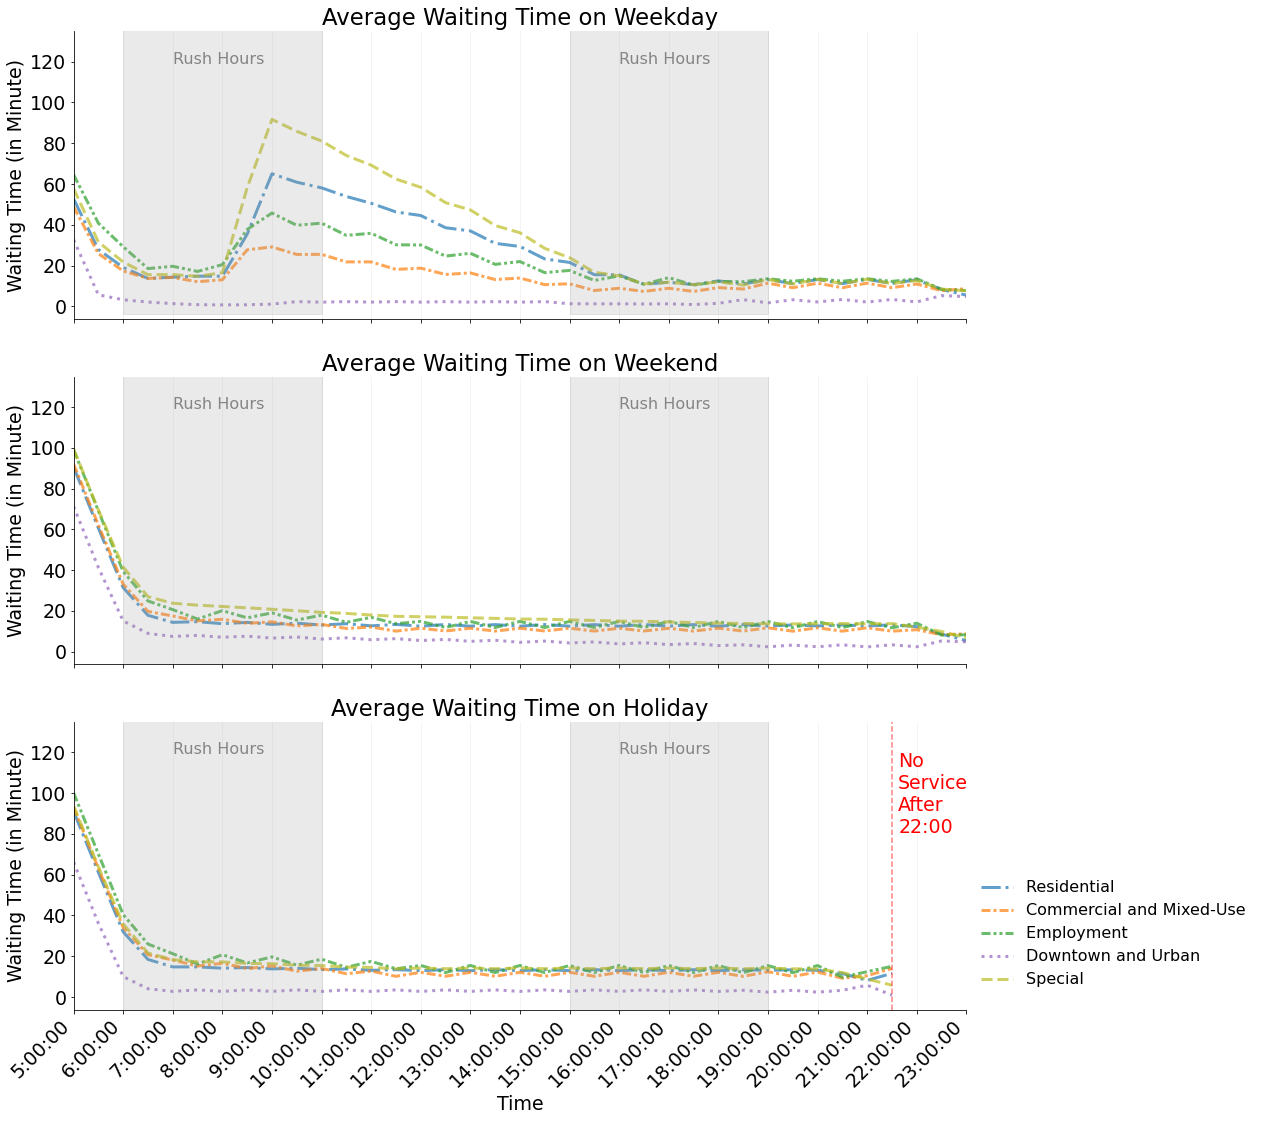

In [105]:
fig, ((ax0), (ax1), (ax2)) = plt.subplots(figsize=(16, 18), nrows=3, sharex=True, sharey=True)
plt.rcParams["font.size"] = 19

colors = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:olive"]

ax0.plot(dfs[0].index, dfs[0][ds[0]], label=ds[0][:ds[0].index("Dist")], color=colors[0], linestyle="dashdot", linewidth=3, alpha=0.7)
ax0.plot(dfs[0].index, dfs[0][ds[1]], label=ds[1][:ds[1].index("Dist")], color=colors[1], linestyle=(0, (3, 1, 1, 1)), linewidth=3, alpha=0.7)
ax0.plot(dfs[0].index, dfs[0][ds[2]], label=ds[2][:ds[2].index("Dist")], color=colors[2], linestyle=(0, (3, 1, 1, 1, 1, 1)), linewidth=3, alpha=0.7)
ax0.plot(dfs[0].index, dfs[0][ds[3]], label=ds[3][:ds[3].index("Dist")], color=colors[3], linestyle="dotted", linewidth=3, alpha=0.7)
ax0.plot(dfs[0].index, dfs[0][ds[4]], label=ds[4][:ds[4].index("Dist")], color=colors[4], linestyle="dashed", linewidth=3, alpha=0.7)

# ax0.set_xlim((0, 36))
# ax0.set_xticks(np.arange(0, 37, 2))
# ax0.set_xticklabels([dts[i] for i in range(len(dts)) if i % 2 == 0],
#                    rotation=45, ha="right")
# ax0.set_xlabel("Time")

ax0.set_ylim((ax0.get_ylim()[0], 135))
ax0.set_ylabel("Waiting Time (in Minute)")


rush_hour1 = plt.Rectangle((2, ax0.get_ylim()[0]), 8, 145,
                     color="0.6", zorder=10, alpha=0.2, transform=ax0.transData)
rush_hour2 = plt.Rectangle((20, ax0.get_ylim()[0]), 8, 145,
                     color="0.6", zorder=10, alpha=0.2, transform=ax0.transData)
ax0.add_artist(rush_hour1)
ax0.add_artist(rush_hour2)

ax0.text(4, ax0.get_ylim()[1] - 10, "Rush Hours", va="top", ha="left", color="0.5", size=16)
ax0.text(22, ax0.get_ylim()[1] - 10, "Rush Hours", va="top", ha="left", color="0.5", size=16)


ax0.set_title("Average Waiting Time" + get_service_type("wkd"))
ax0.grid(axis='x', color='0.95')
# ax0.legend(frameon=False, fontsize=16, bbox_to_anchor=(1.0, 0.5))
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

ax1.plot(dfs[1].index, dfs[1][ds[0]], label=ds[0][:ds[0].index("Dist")], color=colors[0], linestyle="dashdot", linewidth=3, alpha=0.7)
ax1.plot(dfs[1].index, dfs[1][ds[1]], label=ds[1][:ds[1].index("Dist")], color=colors[1], linestyle=(0, (3, 1, 1, 1)), linewidth=3, alpha=0.7)
ax1.plot(dfs[1].index, dfs[1][ds[2]], label=ds[2][:ds[2].index("Dist")], color=colors[2], linestyle=(0, (3, 1, 1, 1, 1, 1)), linewidth=3, alpha=0.7)
ax1.plot(dfs[1].index, dfs[1][ds[3]], label=ds[3][:ds[3].index("Dist")], color=colors[3], linestyle="dotted", linewidth=3, alpha=0.7)
ax1.plot(dfs[1].index, dfs[1][ds[4]], label=ds[4][:ds[4].index("Dist")], color=colors[4], linestyle="dashed", linewidth=3, alpha=0.7)

# ax1.set_xlim((0, 36))
# ax1.set_xticks(np.arange(0, 37, 2))
# ax1.set_xticklabels([dts[i] for i in range(len(dts)) if i % 2 == 0],
#                    rotation=45, ha="right")
# ax1.set_xlabel("Time")

ax1.set_ylim((ax.get_ylim()[0], 135))
ax1.set_ylabel("Waiting Time (in Minute)")


rush_hour1 = plt.Rectangle((2, ax1.get_ylim()[0]), 8, 145,
                     color="0.6", zorder=10, alpha=0.2, transform=ax1.transData)
rush_hour2 = plt.Rectangle((20, ax1.get_ylim()[0]), 8, 145,
                     color="0.6", zorder=10, alpha=0.2, transform=ax1.transData)
ax1.add_artist(rush_hour1)
ax1.add_artist(rush_hour2)

ax1.text(4, ax.get_ylim()[1] - 10, "Rush Hours", va="top", ha="left", color="0.5", size=16)
ax1.text(22, ax.get_ylim()[1] - 10, "Rush Hours", va="top", ha="left", color="0.5", size=16)


ax1.set_title("Average Waiting Time" + get_service_type("sat"))
ax1.grid(axis='x', color='0.95')
# ax1.legend(frameon=False, fontsize=16, bbox_to_anchor=(1.0, 0.5))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2.plot(dfs[2].index, dfs[2][ds[0]], label=ds[0][:ds[0].index("Dist")], color=colors[0], linestyle="dashdot", linewidth=3, alpha=0.7)
ax2.plot(dfs[2].index, dfs[2][ds[1]], label=ds[1][:ds[1].index("Dist")], color=colors[1], linestyle=(0, (3, 1, 1, 1)), linewidth=3, alpha=0.7)
ax2.plot(dfs[2].index, dfs[2][ds[2]], label=ds[2][:ds[2].index("Dist")], color=colors[2], linestyle=(0, (3, 1, 1, 1, 1, 1)), linewidth=3, alpha=0.7)
ax2.plot(dfs[2].index, dfs[2][ds[3]], label=ds[3][:ds[3].index("Dist")], color=colors[3], linestyle="dotted", linewidth=3, alpha=0.7)
ax2.plot(dfs[2].index, dfs[2][ds[4]], label=ds[4][:ds[4].index("Dist")], color=colors[4], linestyle="dashed", linewidth=3, alpha=0.7)

ax2.set_xlim((0, 36))
ax2.set_xticks(np.arange(0, 37, 2))
ax2.set_xticklabels([dts[i] for i in range(len(dts)) if i % 2 == 0],
                   rotation=45, ha="right")
ax2.set_xlabel("Time")

ax2.set_ylim((ax2.get_ylim()[0], 135))
ax2.set_yticks(np.arange(0, 140, 20))
ax2.set_yticklabels(np.arange(0, 140, 20),
                    ha="right")
ax2.set_ylabel("Waiting Time (in Minute)")


rush_hour1 = plt.Rectangle((2, ax2.get_ylim()[0]), 8, 145,
                     color="0.6", zorder=10, alpha=0.2, transform=ax2.transData)
rush_hour2 = plt.Rectangle((20, ax2.get_ylim()[0]), 8, 145,
                     color="0.6", zorder=10, alpha=0.2, transform=ax2.transData)
no_service = plt.Line2D((33, 33), (ax2.get_ylim()[0], 145), color="r", linestyle="--", alpha=0.5)
ax2.text(33.25, 120, "No\nService\nAfter\n22:00", va="top", ha="left", color="r")
ax2.add_artist(no_service)
ax2.add_artist(rush_hour1)
ax2.add_artist(rush_hour2)

ax2.text(4, ax2.get_ylim()[1] - 10, "Rush Hours", va="top", ha="left", color="0.5", size=16)
ax2.text(22, ax2.get_ylim()[1] - 10, "Rush Hours", va="top", ha="left", color="0.5", size=16)


ax2.set_title("Average Waiting Time" + get_service_type(serv))
ax2.grid(axis='x', color='0.95')
ax2.legend(frameon=False, fontsize=16, bbox_to_anchor=(1.0, 0.5))
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.savefig("comb-2.png", dpi=300, bbox_inches="tight")


In [6]:
# start = time.time()
pts, s1 = generate_sim(800, datetime.time(7, 30, 00), "wkd", stops_df, stop_times_df, trips_df)
_, s2 = generate_sim(800, datetime.time(12, 30, 00), "wkd", stops_df, stop_times_df, trips_df, coords=pts)
_, s3 = generate_sim(800, datetime.time(17, 30, 00), "wkd", stops_df, stop_times_df, trips_df, coords=pts)
_, s4 = generate_sim(800, datetime.time(7, 30, 00), "sat", stops_df, stop_times_df, trips_df, coords=pts)
_, s5 = generate_sim(800, datetime.time(12, 30, 00), "sat", stops_df, stop_times_df, trips_df, coords=pts)
_, s6 = generate_sim(800, datetime.time(17, 30, 00), "sat", stops_df, stop_times_df, trips_df, coords=pts)
_, s7 = generate_sim(800, datetime.time(7, 30, 00), "hol", stops_df, stop_times_df, trips_df, coords=pts)
_, s8 = generate_sim(800, datetime.time(12, 30, 00), "hol", stops_df, stop_times_df, trips_df, coords=pts)
_, s9 = generate_sim(800, datetime.time(17, 30, 00), "hol", stops_df, stop_times_df, trips_df, coords=pts)
end = time.time()
# print("total execution time " + str(round((end - start) * 1000, 2)) + "ms")

generate random points 1288.34ms
find near stops 14736.12ms
find waiting time 39533.19ms
find near stops 12180.41ms
find waiting time 38185.12ms
find near stops 12073.04ms
find waiting time 38669.99ms
find near stops 12055.39ms
find waiting time 33257.6ms
find near stops 12445.73ms
find waiting time 33247.68ms
find near stops 12189.69ms
find waiting time 33239.11ms
find near stops 12140.04ms
find waiting time 32081.48ms
find near stops 12057.98ms
find waiting time 32188.22ms
find near stops 15443.05ms
find waiting time 33300.28ms


In [7]:
ds  = list(zone_category.keys())[:5]
d1_1 = s1[s1["districts"] == ds[0]]
d1_2 = s1[s1["districts"] == ds[1]]
d1_3 = s1[s1["districts"] == ds[2]]
d1_4 = s1[s1["districts"] == ds[3]]
d1_5 = s1[s1["districts"] == ds[4]]

d2_1 = s2[s2["districts"] == ds[0]]
d2_2 = s2[s2["districts"] == ds[1]]
d2_3 = s2[s2["districts"] == ds[2]]
d2_4 = s2[s2["districts"] == ds[3]]
d2_5 = s2[s2["districts"] == ds[4]]

d3_1 = s3[s3["districts"] == ds[0]]
d3_2 = s3[s3["districts"] == ds[1]]
d3_3 = s3[s3["districts"] == ds[2]]
d3_4 = s3[s3["districts"] == ds[3]]
d3_5 = s3[s3["districts"] == ds[4]]

d4_1 = s4[s4["districts"] == ds[0]]
d4_2 = s4[s4["districts"] == ds[1]]
d4_3 = s4[s4["districts"] == ds[2]]
d4_4 = s4[s4["districts"] == ds[3]]
d4_5 = s4[s4["districts"] == ds[4]]

d5_1 = s5[s5["districts"] == ds[0]]
d5_2 = s5[s5["districts"] == ds[1]]
d5_3 = s5[s5["districts"] == ds[2]]
d5_4 = s5[s5["districts"] == ds[3]]
d5_5 = s5[s5["districts"] == ds[4]]

d6_1 = s6[s6["districts"] == ds[0]]
d6_2 = s6[s6["districts"] == ds[1]]
d6_3 = s6[s6["districts"] == ds[2]]
d6_4 = s6[s6["districts"] == ds[3]]
d6_5 = s6[s6["districts"] == ds[4]]

d7_1 = s7[s7["districts"] == ds[0]]
d7_2 = s7[s7["districts"] == ds[1]]
d7_3 = s7[s7["districts"] == ds[2]]
d7_4 = s7[s7["districts"] == ds[3]]
d7_5 = s7[s7["districts"] == ds[4]]

d8_1 = s8[s8["districts"] == ds[0]]
d8_2 = s8[s8["districts"] == ds[1]]
d8_3 = s8[s8["districts"] == ds[2]]
d8_4 = s8[s8["districts"] == ds[3]]
d8_5 = s8[s8["districts"] == ds[4]]

d9_1 = s9[s9["districts"] == ds[0]]
d9_2 = s9[s9["districts"] == ds[1]]
d9_3 = s9[s9["districts"] == ds[2]]
d9_4 = s9[s9["districts"] == ds[3]]
d9_5 = s9[s9["districts"] == ds[4]]


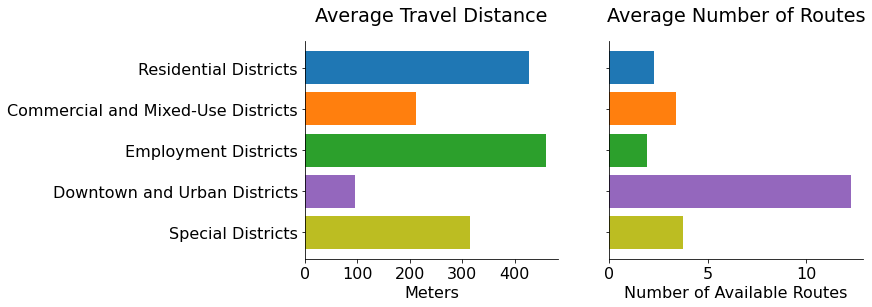

In [16]:
# test4-combination-route-distance

colors = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:olive"]
#####################  REPORT of 1116.md  #####################

fig, ((ax1, ax2)) = plt.subplots(ncols=2,
                                 figsize=(10, 4),
                                 sharey=True)
plt.rcParams["font.size"] = 16
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False


# ax1 7:30 weekday walking distance to bus stops
ax1.barh(ds, [d1_1["distance (nearest, in meters)"].mean(),
              d1_2["distance (nearest, in meters)"].mean(),
              d1_3["distance (nearest, in meters)"].mean(),
              d1_4["distance (nearest, in meters)"].mean(),
              d1_5["distance (nearest, in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_title('Average Travel Distance', pad=20)
ax1.set_xlabel('Meters')

# ax2 7:30 weekday number of available routes
ax2.barh(ds, [d1_1["num_available_routes (within 400m)"].mean(),
              d1_2["num_available_routes (within 400m)"].mean(),
              d1_3["num_available_routes (within 400m)"].mean(),
              d1_4["num_available_routes (within 400m)"].mean(),
              d1_5["num_available_routes (within 400m)"].mean()], align='center', color=colors, linewidth=3.5)
# ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_title('Average Number of Routes', pad=20)
ax2.set_xlabel('Number of Available Routes')

plt.savefig("test4-combination-route-distance.png", dpi=300, bbox_inches="tight")

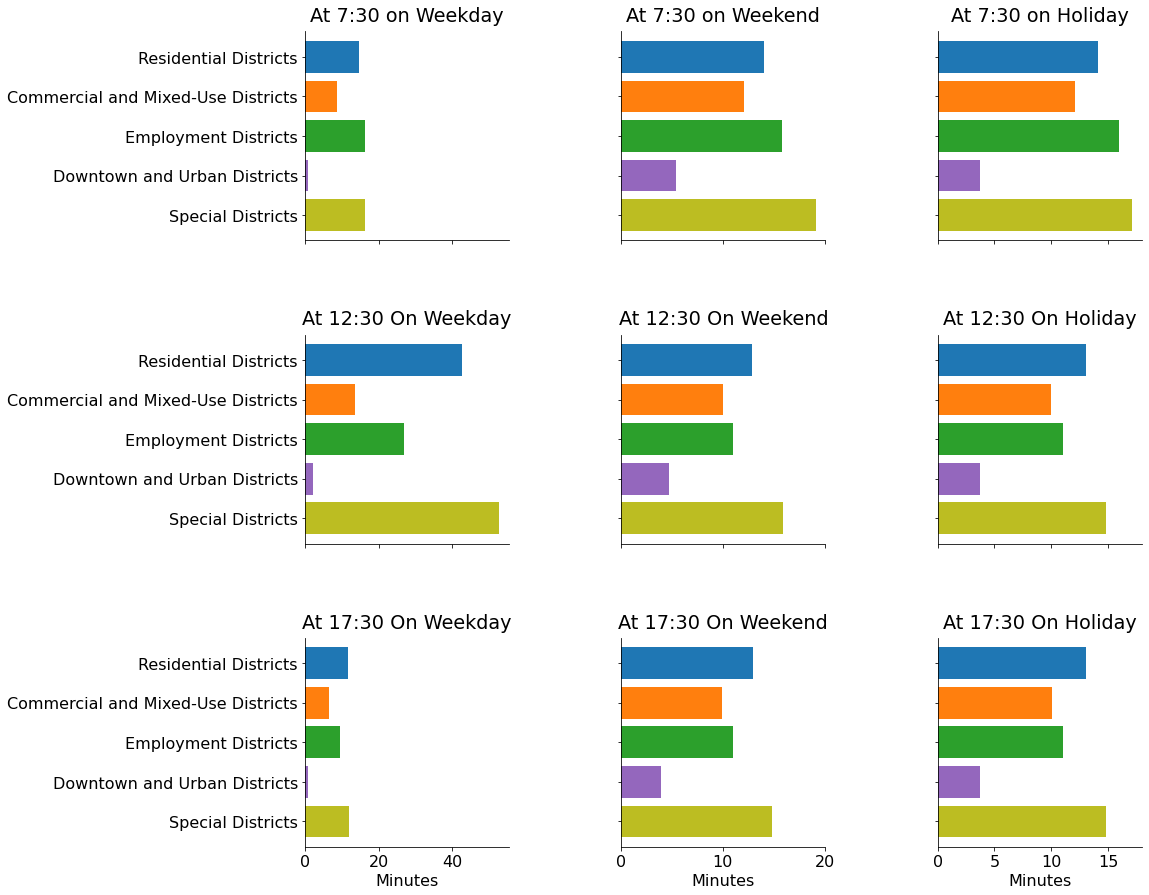

In [9]:
#####################  wkd  #####################
fig, ((ax31, ax32, ax33),
      (ax61, ax62, ax63),
      (ax91, ax92, ax93)) = plt.subplots(nrows=3, ncols=3,
                                         figsize=(15, 15),
                                         sharey=True, sharex='col')
plt.rcParams["font.size"] = 16
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.subplots_adjust(hspace=0.45, wspace=0.55)


##################### ax1 - 3:  #####################


# ax3 7:30 weekday waiting time
ax31.barh(ds, [d1_1["minutes_wait"].dropna().mean(),
              d1_2["minutes_wait"].dropna().mean(),
              d1_3["minutes_wait"].dropna().mean(),
              d1_4["minutes_wait"].dropna().mean(),
              d1_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax31.invert_yaxis()  # labels read top-to-bottom
ax31.set_title('At 7:30 on Weekday', pad=10)
# ax31.set_xlabel('Minutes')

# ax3 7:30 Weekend waiting time
ax32.barh(ds, [d4_1["minutes_wait"].dropna().mean(),
              d4_2["minutes_wait"].dropna().mean(),
              d4_3["minutes_wait"].dropna().mean(),
              d4_4["minutes_wait"].dropna().mean(),
              d4_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax32.invert_yaxis()  # labels read top-to-bottom
ax32.set_title('At 7:30 on Weekend', pad=10)
# ax32.set_xlabel('Minutes')

# ax3 7:30 Holiday waiting time
ax33.barh(ds, [d7_1["minutes_wait"].dropna().mean(),
              d7_2["minutes_wait"].dropna().mean(),
              d7_3["minutes_wait"].dropna().mean(),
              d7_4["minutes_wait"].dropna().mean(),
              d7_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax33.invert_yaxis()  # labels read top-to-bottom
ax33.set_title('At 7:30 on Holiday', pad=10)
# ax33.set_xlabel('Minutes')

##################### ax4 - 6:  #####################
# ax4 12:30 weekday walking distance to bus stops
# ax4.barh(ds, [d2_1["distance (nearest, in meters)"].mean(),
#               d2_2["distance (nearest, in meters)"].mean(),
#               d2_3["distance (nearest, in meters)"].mean(),
#               d2_4["distance (nearest, in meters)"].mean(),
#               d2_5["distance (nearest, in meters)"].mean()], align='center', color=colors, linewidth=3.5)
# ax4.invert_yaxis()  # labels read top-to-bottom
# # ax4.set_title('At 12:30 On Weekday')
# # ax4.set_xlabel('Meters')

# # ax5 12:30 weekday number of available routes
# ax5.barh(ds, [d2_1["num_available_routes (within 400m)"].mean(),
#               d2_2["num_available_routes (within 400m)"].mean(),
#               d2_3["num_available_routes (within 400m)"].mean(),
#               d2_4["num_available_routes (within 400m)"].mean(),
#               d2_5["num_available_routes (within 400m)"].mean()], align='center', color=colors, linewidth=3.5)
# ax5.invert_yaxis()  # labels read top-to-bottom
# # ax5.set_title('At 12:30 On Weekday')
# # ax5.set_xlabel('Number of Available Routes')

# ax6 12:30 weekday waiting time
ax61.barh(ds, [d2_1["minutes_wait"].dropna().mean(),
              d2_2["minutes_wait"].dropna().mean(),
              d2_3["minutes_wait"].dropna().mean(),
              d2_4["minutes_wait"].dropna().mean(),
              d2_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax61.invert_yaxis()  # labels read top-to-bottom
ax61.set_title('At 12:30 On Weekday', pad=10)
# ax61.set_xlabel('Minutes')

# ax6 12:30 Weekend waiting time
ax62.barh(ds, [d5_1["minutes_wait"].dropna().mean(),
              d5_2["minutes_wait"].dropna().mean(),
              d5_3["minutes_wait"].dropna().mean(),
              d5_4["minutes_wait"].dropna().mean(),
              d5_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax62.invert_yaxis()  # labels read top-to-bottom
ax62.set_title('At 12:30 On Weekend', pad=10)
# ax62.set_xlabel('Minutes')

# ax6 12:30 Holiday waiting time
ax63.barh(ds, [d8_1["minutes_wait"].dropna().mean(),
              d8_2["minutes_wait"].dropna().mean(),
              d8_3["minutes_wait"].dropna().mean(),
              d8_4["minutes_wait"].dropna().mean(),
              d8_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax63.invert_yaxis()  # labels read top-to-bottom
ax63.set_title('At 12:30 On Holiday', pad=10)
# ax63.set_xlabel('Minutes')


##################### ax7 - 9:  #####################
# # ax7 17:30 weekday walking distance to bus stops
# ax7.barh(ds, [d1_1["distance (nearest, in meters)"].mean(),
#               d2_2["distance (nearest, in meters)"].mean(),
#               d3_3["distance (nearest, in meters)"].mean(),
#               d4_4["distance (nearest, in meters)"].mean(),
#               d5_5["distance (nearest, in meters)"].mean()], align='center', color=colors, linewidth=3.5)
# ax7.invert_yaxis()  # labels read top-to-bottom
# # ax7.set_title('At 17:30 On Weekday')
# ax7.set_xlabel('Meters')
#
# # ax8 17:30 weekday number of available routes
# ax8.barh(ds, [d3_1["num_available_routes (within 400m)"].mean(),
#               d3_2["num_available_routes (within 400m)"].mean(),
#               d3_3["num_available_routes (within 400m)"].mean(),
#               d3_4["num_available_routes (within 400m)"].mean(),
#               d3_5["num_available_routes (within 400m)"].mean()], align='center', color=colors, linewidth=3.5)
# ax8.invert_yaxis()  # labels read top-to-bottom
# # ax8.set_title('At 17:30 On Weekday')
# ax8.set_xlabel('Number of Available Routes')

# ax9 17:30 weekday waiting time
ax91.barh(ds, [d3_1["minutes_wait"].dropna().mean(),
              d3_2["minutes_wait"].dropna().mean(),
              d3_3["minutes_wait"].dropna().mean(),
              d3_4["minutes_wait"].dropna().mean(),
              d3_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax91.invert_yaxis()  # labels read top-to-bottom
ax91.set_title('At 17:30 On Weekday', pad=10)
ax91.set_xlabel('Minutes')

# ax9 17:30 Weekend waiting time
ax92.barh(ds, [d6_1["minutes_wait"].dropna().mean(),
              d6_2["minutes_wait"].dropna().mean(),
              d6_3["minutes_wait"].dropna().mean(),
              d6_4["minutes_wait"].dropna().mean(),
              d6_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax92.invert_yaxis()  # labels read top-to-bottom
ax92.set_title('At 17:30 On Weekend', pad=10)
ax92.set_xlabel('Minutes')

# ax9 17:30 Holiday waiting time
ax93.barh(ds, [d9_1["minutes_wait"].dropna().mean(),
              d9_2["minutes_wait"].dropna().mean(),
              d9_3["minutes_wait"].dropna().mean(),
              d9_4["minutes_wait"].dropna().mean(),
              d9_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax93.invert_yaxis()  # labels read top-to-bottom
ax93.set_title('At 17:30 On Holiday', pad=10)
ax93.set_xlabel('Minutes')


plt.savefig("test4-combination-peak.png", dpi=300, bbox_inches="tight")

In [11]:
# off peak

# start = time.time()
pts, os1 = generate_sim(800, datetime.time(10, 30, 00), "wkd", stops_df, stop_times_df, trips_df)
_, os2 = generate_sim(800, datetime.time(15, 30, 00), "wkd", stops_df, stop_times_df, trips_df, coords=pts)
_, os3 = generate_sim(800, datetime.time(21, 30, 00), "wkd", stops_df, stop_times_df, trips_df, coords=pts)
_, os4 = generate_sim(800, datetime.time(10, 30, 00), "sat", stops_df, stop_times_df, trips_df, coords=pts)
_, os5 = generate_sim(800, datetime.time(15, 30, 00), "sat", stops_df, stop_times_df, trips_df, coords=pts)
_, os6 = generate_sim(800, datetime.time(21, 30, 00), "sat", stops_df, stop_times_df, trips_df, coords=pts)
_, os7 = generate_sim(800, datetime.time(10, 30, 00), "hol", stops_df, stop_times_df, trips_df, coords=pts)
_, os8 = generate_sim(800, datetime.time(15, 30, 00), "hol", stops_df, stop_times_df, trips_df, coords=pts)
_, os9 = generate_sim(800, datetime.time(21, 30, 00), "hol", stops_df, stop_times_df, trips_df, coords=pts)
end = time.time()
# print("total execution time " + str(round((end - start) * 1000, 2)) + "ms")

generate random points 1577.67ms
find near stops 14090.32ms
find waiting time 43112.31ms
find near stops 13319.28ms
find waiting time 43188.12ms
find near stops 13271.87ms
find waiting time 43583.45ms
find near stops 14290.01ms
find waiting time 37039.78ms
find near stops 12173.78ms
find waiting time 33744.37ms
find near stops 12087.85ms
find waiting time 33457.69ms
find near stops 12103.52ms
find waiting time 32026.86ms
find near stops 12392.86ms
find waiting time 32049.04ms
find near stops 12142.07ms
find waiting time 29239.96ms


In [14]:
ds  = list(zone_category.keys())[:5]
od1_1 = os1[os1["districts"] == ds[0]]
od1_2 = os1[os1["districts"] == ds[1]]
od1_3 = os1[os1["districts"] == ds[2]]
od1_4 = os1[os1["districts"] == ds[3]]
od1_5 = os1[os1["districts"] == ds[4]]

od2_1 = os2[os2["districts"] == ds[0]]
od2_2 = os2[os2["districts"] == ds[1]]
od2_3 = os2[os2["districts"] == ds[2]]
od2_4 = os2[os2["districts"] == ds[3]]
od2_5 = os2[os2["districts"] == ds[4]]

od3_1 = os3[os3["districts"] == ds[0]]
od3_2 = os3[os3["districts"] == ds[1]]
od3_3 = os3[os3["districts"] == ds[2]]
od3_4 = os3[os3["districts"] == ds[3]]
od3_5 = os3[os3["districts"] == ds[4]]

od4_1 = os4[os4["districts"] == ds[0]]
od4_2 = os4[os4["districts"] == ds[1]]
od4_3 = os4[os4["districts"] == ds[2]]
od4_4 = os4[os4["districts"] == ds[3]]
od4_5 = os4[os4["districts"] == ds[4]]

od5_1 = os5[os5["districts"] == ds[0]]
od5_2 = os5[os5["districts"] == ds[1]]
od5_3 = os5[os5["districts"] == ds[2]]
od5_4 = os5[os5["districts"] == ds[3]]
od5_5 = os5[os5["districts"] == ds[4]]

od6_1 = os6[os6["districts"] == ds[0]]
od6_2 = os6[os6["districts"] == ds[1]]
od6_3 = os6[os6["districts"] == ds[2]]
od6_4 = os6[os6["districts"] == ds[3]]
od6_5 = os6[os6["districts"] == ds[4]]

od7_1 = os7[os7["districts"] == ds[0]]
od7_2 = os7[os7["districts"] == ds[1]]
od7_3 = os7[os7["districts"] == ds[2]]
od7_4 = os7[os7["districts"] == ds[3]]
od7_5 = os7[os7["districts"] == ds[4]]

od8_1 = os8[os8["districts"] == ds[0]]
od8_2 = os8[os8["districts"] == ds[1]]
od8_3 = os8[os8["districts"] == ds[2]]
od8_4 = os8[os8["districts"] == ds[3]]
od8_5 = os8[os8["districts"] == ds[4]]

od9_1 = os9[os9["districts"] == ds[0]]
od9_2 = os9[os9["districts"] == ds[1]]
od9_3 = os9[os9["districts"] == ds[2]]
od9_4 = os9[os9["districts"] == ds[3]]
od9_5 = os9[os9["districts"] == ds[4]]


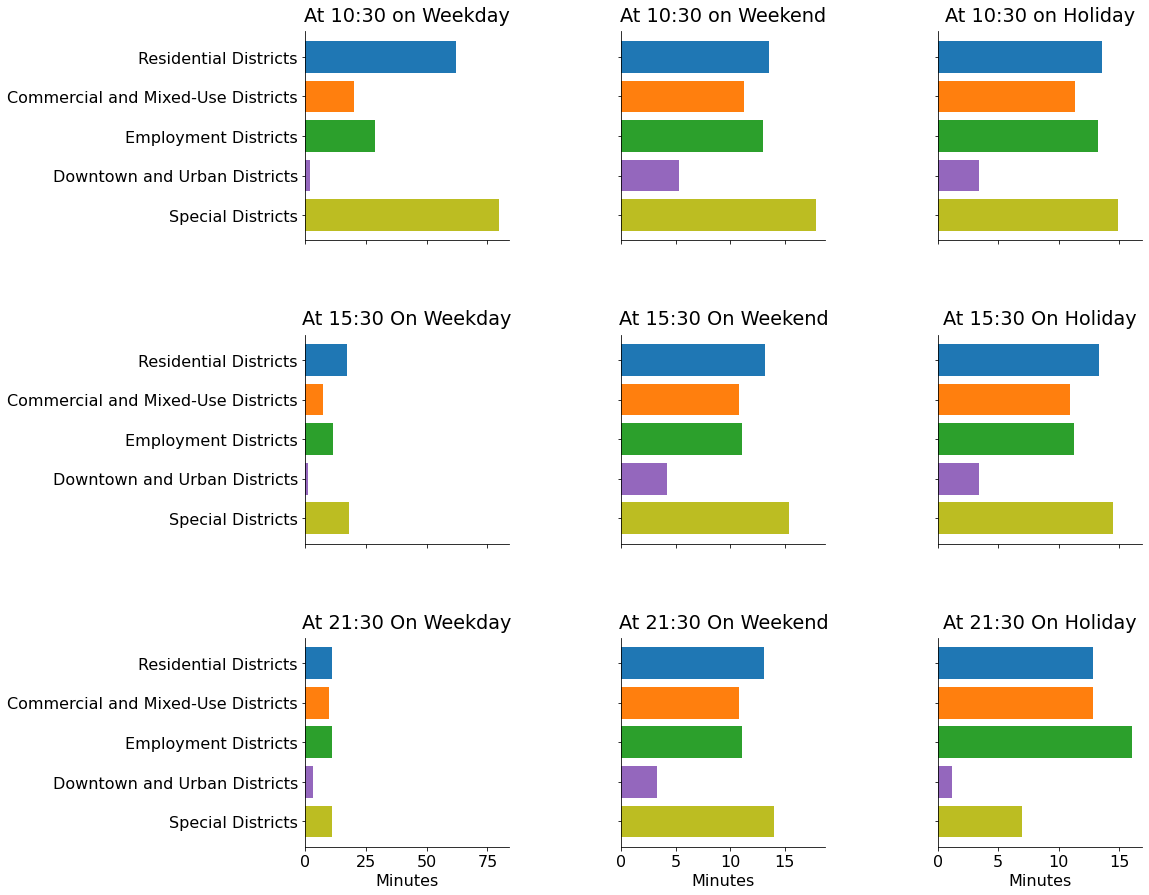

In [15]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:olive"]
#####################  REPORT of 1116.md  #####################

#####################  wkd  #####################
fig, ((ax31, ax32, ax33),
      (ax61, ax62, ax63),
      (ax91, ax92, ax93)) = plt.subplots(nrows=3, ncols=3,
                                                   figsize=(15, 15),
                                                   sharey=True, sharex='col')
plt.rcParams["font.size"] = 16
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.subplots_adjust(hspace=0.45, wspace=0.55)


##################### ax1 - 3:  #####################
# ax1 7:30 weekday walking distance to bus stops
# ax1.barh(ds, [d1_1["distance (nearest, in meters)"].mean(),
#               d1_2["distance (nearest, in meters)"].mean(),
#               d1_3["distance (nearest, in meters)"].mean(),
#               d1_4["distance (nearest, in meters)"].mean(),
#               d1_5["distance (nearest, in meters)"].mean()], align='center', color=colors, linewidth=3.5)
# ax1.invert_yaxis()  # labels read top-to-bottom
# ax1.set_title('Average Travel Distance', pad=20)
# # ax1.set_xlabel('Meters')
#
# # ax2 7:30 weekday number of available routes
# ax2.barh(ds, [d1_1["num_available_routes (within 400m)"].mean(),
#               d1_2["num_available_routes (within 400m)"].mean(),
#               d1_3["num_available_routes (within 400m)"].mean(),
#               d1_4["num_available_routes (within 400m)"].mean(),
#               d1_5["num_available_routes (within 400m)"].mean()], align='center', color=colors, linewidth=3.5)
# ax2.invert_yaxis()  # labels read top-to-bottom
# ax2.set_title('Average Number of Routes', pad=20)
# # ax2.set_xlabel('Number of Available Routes')

# ax3 7:30 weekday waiting time
ax31.barh(ds, [od1_1["minutes_wait"].dropna().mean(),
              od1_2["minutes_wait"].dropna().mean(),
              od1_3["minutes_wait"].dropna().mean(),
              od1_4["minutes_wait"].dropna().mean(),
              od1_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax31.invert_yaxis()  # labels read top-to-bottom
ax31.set_title('At 10:30 on Weekday', pad=10)
# ax31.set_xlabel('Minutes')

# ax3 7:30 Weekend waiting time
ax32.barh(ds, [od4_1["minutes_wait"].dropna().mean(),
              od4_2["minutes_wait"].dropna().mean(),
              od4_3["minutes_wait"].dropna().mean(),
              od4_4["minutes_wait"].dropna().mean(),
              od4_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax32.invert_yaxis()  # labels read top-to-bottom
ax32.set_title('At 10:30 on Weekend', pad=10)
# ax32.set_xlabel('Minutes')

# ax3 7:30 Holiday waiting time
ax33.barh(ds, [od7_1["minutes_wait"].dropna().mean(),
              od7_2["minutes_wait"].dropna().mean(),
              od7_3["minutes_wait"].dropna().mean(),
              od7_4["minutes_wait"].dropna().mean(),
              od7_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax33.invert_yaxis()  # labels read top-to-bottom
ax33.set_title('At 10:30 on Holiday', pad=10)
# ax33.set_xlabel('Minutes')

##################### ax4 - 6:  #####################
# # ax4 12:30 weekday walking distance to bus stops
# ax4.barh(ds, [d2_1["distance (nearest, in meters)"].mean(),
#               d2_2["distance (nearest, in meters)"].mean(),
#               d2_3["distance (nearest, in meters)"].mean(),
#               d2_4["distance (nearest, in meters)"].mean(),
#               d2_5["distance (nearest, in meters)"].mean()], align='center', color=colors, linewidth=3.5)
# ax4.invert_yaxis()  # labels read top-to-bottom
# # ax4.set_title('At 12:30 On Weekday')
# # ax4.set_xlabel('Meters')
#
# # ax5 12:30 weekday number of available routes
# ax5.barh(ds, [d2_1["num_available_routes (within 400m)"].mean(),
#               d2_2["num_available_routes (within 400m)"].mean(),
#               d2_3["num_available_routes (within 400m)"].mean(),
#               d2_4["num_available_routes (within 400m)"].mean(),
#               d2_5["num_available_routes (within 400m)"].mean()], align='center', color=colors, linewidth=3.5)
# ax5.invert_yaxis()  # labels read top-to-bottom
# # ax5.set_title('At 12:30 On Weekday')
# # ax5.set_xlabel('Number of Available Routes')

# ax6 12:30 weekday waiting time
ax61.barh(ds, [od2_1["minutes_wait"].dropna().mean(),
              od2_2["minutes_wait"].dropna().mean(),
              od2_3["minutes_wait"].dropna().mean(),
              od2_4["minutes_wait"].dropna().mean(),
              od2_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax61.invert_yaxis()  # labels read top-to-bottom
ax61.set_title('At 15:30 On Weekday', pad=10)
# ax61.set_xlabel('Minutes')

# ax6 12:30 Weekend waiting time
ax62.barh(ds, [od5_1["minutes_wait"].dropna().mean(),
              od5_2["minutes_wait"].dropna().mean(),
              od5_3["minutes_wait"].dropna().mean(),
              od5_4["minutes_wait"].dropna().mean(),
              od5_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax62.invert_yaxis()  # labels read top-to-bottom
ax62.set_title('At 15:30 On Weekend', pad=10)
# ax62.set_xlabel('Minutes')

# ax6 12:30 Holiday waiting time
ax63.barh(ds, [od8_1["minutes_wait"].dropna().mean(),
              od8_2["minutes_wait"].dropna().mean(),
              od8_3["minutes_wait"].dropna().mean(),
              od8_4["minutes_wait"].dropna().mean(),
              od8_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax63.invert_yaxis()  # labels read top-to-bottom
ax63.set_title('At 15:30 On Holiday', pad=10)
# ax63.set_xlabel('Minutes')


##################### ax7 - 9:  #####################
# # ax7 17:30 weekday walking distance to bus stops
# ax7.barh(ds, [d1_1["distance (nearest, in meters)"].mean(),
#               d2_2["distance (nearest, in meters)"].mean(),
#               d3_3["distance (nearest, in meters)"].mean(),
#               d4_4["distance (nearest, in meters)"].mean(),
#               d5_5["distance (nearest, in meters)"].mean()], align='center', color=colors, linewidth=3.5)
# ax7.invert_yaxis()  # labels read top-to-bottom
# # ax7.set_title('At 17:30 On Weekday')
# ax7.set_xlabel('Meters')
#
# # ax8 17:30 weekday number of available routes
# ax8.barh(ds, [d3_1["num_available_routes (within 400m)"].mean(),
#               d3_2["num_available_routes (within 400m)"].mean(),
#               d3_3["num_available_routes (within 400m)"].mean(),
#               d3_4["num_available_routes (within 400m)"].mean(),
#               d3_5["num_available_routes (within 400m)"].mean()], align='center', color=colors, linewidth=3.5)
# ax8.invert_yaxis()  # labels read top-to-bottom
# # ax8.set_title('At 17:30 On Weekday')
# ax8.set_xlabel('Number of Available Routes')

# ax9 17:30 weekday waiting time
ax91.barh(ds, [od3_1["minutes_wait"].dropna().mean(),
              od3_2["minutes_wait"].dropna().mean(),
              od3_3["minutes_wait"].dropna().mean(),
              od3_4["minutes_wait"].dropna().mean(),
              od3_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax91.invert_yaxis()  # labels read top-to-bottom
ax91.set_title('At 21:30 On Weekday', pad=10)
ax91.set_xlabel('Minutes')

# ax9 17:30 Weekend waiting time
ax92.barh(ds, [od6_1["minutes_wait"].dropna().mean(),
              od6_2["minutes_wait"].dropna().mean(),
              od6_3["minutes_wait"].dropna().mean(),
              od6_4["minutes_wait"].dropna().mean(),
              od6_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax92.invert_yaxis()  # labels read top-to-bottom
ax92.set_title('At 21:30 On Weekend', pad=10)
ax92.set_xlabel('Minutes')

# ax9 17:30 Holiday waiting time
ax93.barh(ds, [od9_1["minutes_wait"].dropna().mean(),
              od9_2["minutes_wait"].dropna().mean(),
              od9_3["minutes_wait"].dropna().mean(),
              od9_4["minutes_wait"].dropna().mean(),
              od9_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax93.invert_yaxis()  # labels read top-to-bottom
ax93.set_title('At 21:30 On Holiday', pad=10)
ax93.set_xlabel('Minutes')

# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left=True,      # ticks along the bottom edge are off
#     # labelleft=True) # labels along the bottom edge are off
plt.savefig("test4-combination-off-peak.png", dpi=300, bbox_inches="tight")

,districts,pt_lon,pt_lat,stop_id (nearest),stop_lon (nearest),stop_lat (nearest),"distance (nearest, in meters)",num_available_stops (within 400m),num_available_routes (within 400m),available_routes (within 400m),ids_dist,minutes_wait,trip_id (chosen),stop_id (chosen),coming_route
0,Residential Districts,-89.328914,43.092708,1478,-89.326923,43.093134,168.37,8,2,"[16, 31]","[(1478, 168.37), (1890, 173.51), (1785, 188.48...",5.766667,1021233.0,1225.0,16
1,Residential Districts,-89.360919,43.114396,1759,-89.361072,43.114105,34.64,12,7,"[2, 4, 17, 20, 21, 22, 27]","[(1759, 34.64), (1504, 73.87), (1877, 199.02),...",0.450000,1021450.0,1895.0,17
2,Residential Districts,-89.270656,43.095106,7814,-89.269864,43.091781,375.05,1,1,[33],"[(7814, 375.05)]",26.533333,1023344.0,7814.0,33
3,Residential Districts,-89.441794,43.051976,2593,-89.441664,43.051126,95.03,9,2,"[6, 7]","[(2593, 95.03), (2918, 159.64), (2316, 190.05)...",3.150000,1020425.0,2105.0,7
4,Residential Districts,-89.338037,43.100757,1848,-89.338929,43.099956,114.75,6,2,"[5, 15]","[(1848, 114.75), (1919, 126.68), (1220, 230.71...",1.666667,1019860.0,1975.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,Special Districts,-89.527471,43.035375,8174,-89.525002,43.034346,230.80,4,1,[55],"[(8174, 230.8), (8435, 257.43), (8728, 364.48)...",0.333333,1023804.0,8953.0,55
3996,Special Districts,-89.416816,43.073245,2921,-89.417438,43.073222,50.54,11,9,"[2, 10, 11, 12, 27, 44, 48, 80, 82]","[(2921, 50.54), (2806, 113.87), (692, 208.32),...",1.000000,1024608.0,2978.0,80
3997,Special Districts,-89.397847,43.070902,43,-89.397884,43.070811,10.51,24,17,"[2, 4, 6, 7, 8, 10, 11, 12, 13, 15, 27, 48, 70...","[(43, 10.51), (39, 117.79), (435, 128.72), (68...",1.250000,1020735.0,568.0,8
3998,Special Districts,-89.389171,43.140932,5715,-89.388320,43.139714,151.95,2,1,[22],"[(5715, 151.95), (5397, 289.69)]",14.250000,1022501.0,5397.0,22


In [ ]:
#####################  weekend  #####################
fig, ((ax1, ax2, ax3),
      (ax4, ax5, ax6),
      (ax7, ax8, ax9)) = plt.subplots(ncols=3, nrows=3, figsize=(15, 15), sharey=True)
plt.rcParams["font.size"] = 16
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.subplots_adjust(hspace=0.45, wspace=0.55)


##################### ax1 - 3:  #####################
# ax1 7:30 Weekend walking distance to bus stops
ax1.barh(ds, [d4_1["distance (nearest, in meters)"].mean(),
              d4_2["distance (nearest, in meters)"].mean(),
              d4_3["distance (nearest, in meters)"].mean(),
              d4_4["distance (nearest, in meters)"].mean(),
              d4_5["distance (nearest, in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_title('Average Travel Distance\nAt 7:30 On Weekend')
ax1.set_xlabel('Meters')

# ax2 7:30 weekday number of available routes
ax2.barh(ds, [d4_1["num_available_routes (within 400m)"].mean(),
              d4_2["num_available_routes (within 400m)"].mean(),
              d4_3["num_available_routes (within 400m)"].mean(),
              d4_4["num_available_routes (within 400m)"].mean(),
              d4_5["num_available_routes (within 400m)"].mean()], align='center', color=colors, linewidth=3.5)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_title('Average Number of Routes\nAt 7:30 on Weekend')
ax2.set_xlabel('Number of Available Routes')

# ax3 7:30 Weekend waiting time
ax3.barh(ds, [d4_1["minutes_wait"].dropna().mean(),
              d4_2["minutes_wait"].dropna().mean(),
              d4_3["minutes_wait"].dropna().mean(),
              d4_4["minutes_wait"].dropna().mean(),
              d4_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax3.invert_yaxis()  # labels read top-to-bottom
ax3.set_title('Average Waiting Time\nAt 7:30 on Weekend')
ax3.set_xlabel('Minutes')

##################### ax4 - 6:  #####################
# ax4 12:30 Weekend walking distance to bus stops
ax4.barh(ds, [d5_1["distance (nearest, in meters)"].mean(),
              d5_2["distance (nearest, in meters)"].mean(),
              d5_3["distance (nearest, in meters)"].mean(),
              d5_4["distance (nearest, in meters)"].mean(),
              d5_5["distance (nearest, in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax4.invert_yaxis()  # labels read top-to-bottom
ax4.set_title('At 12:30 On Weekend')
ax4.set_xlabel('Meters')

# ax5 12:30 Weekend number of available routes
ax5.barh(ds, [d5_1["num_available_routes (within 400m)"].mean(),
              d5_2["num_available_routes (within 400m)"].mean(),
              d5_3["num_available_routes (within 400m)"].mean(),
              d5_4["num_available_routes (within 400m)"].mean(),
              d5_5["num_available_routes (within 400m)"].mean()], align='center', color=colors, linewidth=3.5)
ax5.invert_yaxis()  # labels read top-to-bottom
ax5.set_title('At 12:30 On Weekend')
ax5.set_xlabel('Number of Available Routes')

# ax6 12:30 Weekend waiting time
ax6.barh(ds, [d5_1["minutes_wait"].dropna().mean(),
              d5_2["minutes_wait"].dropna().mean(),
              d5_3["minutes_wait"].dropna().mean(),
              d5_4["minutes_wait"].dropna().mean(),
              d5_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax6.invert_yaxis()  # labels read top-to-bottom
ax6.set_title('At 12:30 On Weekend')
ax6.set_xlabel('Minutes')


##################### ax7 - 9:  #####################
# ax7 17:30 Weekend walking distance to bus stops
ax7.barh(ds, [d6_1["distance (nearest, in meters)"].mean(),
              d6_2["distance (nearest, in meters)"].mean(),
              d6_3["distance (nearest, in meters)"].mean(),
              d6_4["distance (nearest, in meters)"].mean(),
              d6_5["distance (nearest, in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax7.invert_yaxis()  # labels read top-to-bottom
ax7.set_title('At 17:30 On Weekend')
ax7.set_xlabel('Meters')

# ax8 17:30 Weekend number of available routes
ax8.barh(ds, [d6_1["num_available_routes (within 400m)"].mean(),
              d6_2["num_available_routes (within 400m)"].mean(),
              d6_3["num_available_routes (within 400m)"].mean(),
              d6_4["num_available_routes (within 400m)"].mean(),
              d6_5["num_available_routes (within 400m)"].mean()], align='center', color=colors, linewidth=3.5)
ax8.invert_yaxis()  # labels read top-to-bottom
ax8.set_title('At 17:30 On Weekend')
ax8.set_xlabel('Number of Available Routes')

# ax9 17:30 Weekend waiting time
ax9.barh(ds, [d6_1["minutes_wait"].dropna().mean(),
              d6_2["minutes_wait"].dropna().mean(),
              d6_3["minutes_wait"].dropna().mean(),
              d6_4["minutes_wait"].dropna().mean(),
              d6_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax9.invert_yaxis()  # labels read top-to-bottom
ax9.set_title('At 17:30 On Weekend')
ax9.set_xlabel('Minutes')
plt.savefig("weekend.png", dpi=300, bbox_inches="tight")


In [ ]:
#####################  hol  #####################
fig, ((ax1, ax2, ax3),
      (ax4, ax5, ax6),
      (ax7, ax8, ax9)) = plt.subplots(ncols=3, nrows=3, figsize=(15, 15), sharey=True)
plt.rcParams["font.size"] = 16
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.subplots_adjust(hspace=0.45, wspace=0.55)


##################### ax1 - 3:  #####################
# ax1 7:30 Holiday walking distance to bus stops
ax1.barh(ds, [d7_1["distance (nearest, in meters)"].mean(),
              d7_2["distance (nearest, in meters)"].mean(),
              d7_3["distance (nearest, in meters)"].mean(),
              d7_4["distance (nearest, in meters)"].mean(),
              d7_5["distance (nearest, in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_title('Average Travel Distance\nAt 7:30 On Holiday')
ax1.set_xlabel('Meters')

# ax2 7:30 Holiday number of available routes
ax2.barh(ds, [d7_1["num_available_routes (within 400m)"].mean(),
              d7_2["num_available_routes (within 400m)"].mean(),
              d7_3["num_available_routes (within 400m)"].mean(),
              d7_4["num_available_routes (within 400m)"].mean(),
              d7_5["num_available_routes (within 400m)"].mean()], align='center', color=colors, linewidth=3.5)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_title('Average Number of Routes\nAt 7:30 on Holiday')
ax2.set_xlabel('Number of Available Routes')

# ax3 7:30 Holiday waiting time
ax3.barh(ds, [d7_1["minutes_wait"].dropna().mean(),
              d7_2["minutes_wait"].dropna().mean(),
              d7_3["minutes_wait"].dropna().mean(),
              d7_4["minutes_wait"].dropna().mean(),
              d7_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax3.invert_yaxis()  # labels read top-to-bottom
ax3.set_title('Average Waiting Time\nAt 7:30 on Holiday')
ax3.set_xlabel('Minutes')

##################### ax4 - 6:  #####################
# ax4 12:30 Holiday walking distance to bus stops
ax4.barh(ds, [d8_1["distance (nearest, in meters)"].mean(),
              d8_2["distance (nearest, in meters)"].mean(),
              d8_3["distance (nearest, in meters)"].mean(),
              d8_4["distance (nearest, in meters)"].mean(),
              d8_5["distance (nearest, in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax4.invert_yaxis()  # labels read top-to-bottom
ax4.set_title('At 12:30 On Holiday')
ax4.set_xlabel('Meters')

# ax5 12:30 Holiday number of available routes
ax5.barh(ds, [d8_1["num_available_routes (within 400m)"].mean(),
              d8_2["num_available_routes (within 400m)"].mean(),
              d8_3["num_available_routes (within 400m)"].mean(),
              d8_4["num_available_routes (within 400m)"].mean(),
              d8_5["num_available_routes (within 400m)"].mean()], align='center', color=colors, linewidth=3.5)
ax5.invert_yaxis()  # labels read top-to-bottom
ax5.set_title('At 12:30 On Holiday')
ax5.set_xlabel('Number of Available Routes')

# ax6 12:30 Holiday waiting time
ax6.barh(ds, [d8_1["minutes_wait"].dropna().mean(),
              d8_2["minutes_wait"].dropna().mean(),
              d8_3["minutes_wait"].dropna().mean(),
              d8_4["minutes_wait"].dropna().mean(),
              d8_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax6.invert_yaxis()  # labels read top-to-bottom
ax6.set_title('At 12:30 On Holiday')
ax6.set_xlabel('Minutes')


##################### ax7 - 9:  #####################
# ax7 17:30 Holiday walking distance to bus stops
ax7.barh(ds, [d9_1["distance (nearest, in meters)"].mean(),
              d9_2["distance (nearest, in meters)"].mean(),
              d9_3["distance (nearest, in meters)"].mean(),
              d9_4["distance (nearest, in meters)"].mean(),
              d9_5["distance (nearest, in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax7.invert_yaxis()  # labels read top-to-bottom
ax7.set_title('At 17:30 On Holiday')
ax7.set_xlabel('Meters')

# ax8 17:30 Holiday number of available routes
ax8.barh(ds, [d9_1["num_available_routes (within 400m)"].mean(),
              d9_2["num_available_routes (within 400m)"].mean(),
              d9_3["num_available_routes (within 400m)"].mean(),
              d9_4["num_available_routes (within 400m)"].mean(),
              d9_5["num_available_routes (within 400m)"].mean()], align='center', color=colors, linewidth=3.5)
ax8.invert_yaxis()  # labels read top-to-bottom
ax8.set_title('At 17:30 On Holiday')
ax8.set_xlabel('Number of Available Routes')

# ax9 17:30 Holiday waiting time
ax9.barh(ds, [d9_1["minutes_wait"].dropna().mean(),
              d9_2["minutes_wait"].dropna().mean(),
              d9_3["minutes_wait"].dropna().mean(),
              d9_4["minutes_wait"].dropna().mean(),
              d9_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax9.invert_yaxis()  # labels read top-to-bottom
ax9.set_title('At 17:30 On Holiday')
ax9.set_xlabel('Minutes')
plt.savefig("holiday.png", dpi=300, bbox_inches="tight")




In [ ]:
# li = []
# li.extend(zone_category["Overlay Districts"])
# li.extend(zone_category["Historic Districts"])
# zones[zones["ZONING_COD"].isin(li)]

colors = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:olive"]
zones.head()

In [ ]:

fig, ax = plt.subplots(figsize=(12, 10))
city.plot(ax=ax, color="0.9")
water.plot(ax=ax, color="0.7")
street.plot(ax=ax, color="0.8")

cnt = 0
handles = []
for key, val in zone_category.items():
    print(key)
    if len(zones[zones["ZONING_COD"].isin(zone_category[key])]) == 0:
        continue
    else:
        temp = zones[zones["ZONING_COD"].isin(zone_category[key])]
        c = colors[cnt]
        cnt += 1

        temp.plot(ax=ax, color=c, zorder=2, alpha=0.4, label=key, legend=True)

p0 = Patch(facecolor=colors[0], label=list(zone_category.keys())[0], alpha=0.4)
p1 = Patch(facecolor=colors[1], label=list(zone_category.keys())[1], alpha=0.4)
p2 = Patch(facecolor=colors[2], label=list(zone_category.keys())[2], alpha=0.4)
p3 = Patch(facecolor=colors[3], label=list(zone_category.keys())[3], alpha=0.4)
p4 = Patch(facecolor=colors[4], label=list(zone_category.keys())[4], alpha=0.4)

ax.set_title("Zoning Districts in Madison", size=16)
patches = [p0, p1, p2, p3, p4]
ax.legend(handles=patches, loc='upper left', frameon=False)
ax.set_axis_off()
plt.savefig("../report/11_16th/intro_png", dpi=300, bbox_inches="tight")

